# ライトカーブをシングルフィットして、その残差をt0,teff fitするためのgrid searchを流す

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize as op
import warnings

warnings.filterwarnings("ignore", category=np.RankWarning)

シングルレンズフィットをする関数

In [2]:
def single_magnification(t0,tE,u0,t):
    u = np.sqrt(u0**2 + ((t-t0)/tE)**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2 +4))
    return A

def get_flux_single(t0,tE,u0,data_time,data_flux,data_ferr):
    A = single_magnification(t0,tE,u0,data_time)
    fs, fb = np.polyfit(A, data_flux, 1,w=1/data_ferr)
    return fs, fb
    
def get_chi2_single(t0,tE,u0,data_time,data_flux,data_ferr):
    A = single_magnification(t0,tE,u0,data_time)
    fs, fb = get_flux_single(t0,tE,u0,data_time,data_flux,data_ferr)
    model_flux = A*fs + fb
    chi2 = np.sum(((data_flux-model_flux)/data_ferr)**2)
    return chi2
    
def chi2_fun_single(theta,data_time,data_flux,data_ferr):
    return get_chi2_single(theta[0],theta[1],theta[2],data_time,data_flux,data_ferr)

def single_fit(t0_init,tE_init,u0_init,data_time,data_flux,data_ferr):
    initial_guess = [t0_init, tE_init,u0_init]
    
    result = op.minimize(chi2_fun_single, x0=initial_guess,args=(data_time,data_flux,data_ferr),method='Nelder-Mead')
    
    (fit_t0, fit_tE,fit_u0) = result.x
    return fit_t0, fit_tE, fit_u0

t0,teff fitをするための関数

In [3]:
def calc_A_j_0(t0,teff,t):
    Q = 1+((t-t0)/teff)**2
    A = 1/np.sqrt(Q)  
    return A

def calc_A_j_1(t0,teff,t):
    Q = 1+((t-t0)/teff)**2
    A = (Q+2)/np.sqrt(Q*(Q+4))
    return A

def calc_A_comb(t0,teff,t):
    A_j_0 = calc_A_j_0(t0,teff,t)
    A_j_1 = calc_A_j_1(t0,teff,t)
    A = A_j_0 + A_j_1
    return A
    
def get_chi2_comb(t0,teff,data_time,data_flux,data_ferr):
    A_comb = calc_A_comb(t0,teff,data_time)
    fs, fb = get_flux_comb(t0,teff,data_time,data_flux,data_ferr)
    model_flux = A_comb*fs + fb
    chi2 = np.sum(((data_flux-model_flux)/data_ferr)**2)
    return chi2

def get_flux_comb(t0,teff,data_time,data_flux,data_ferr):
    A_comb = calc_A_comb(t0,teff,data_time)
    f1, f0 = np.polyfit(A_comb, data_flux, 1,w=1/data_ferr)
    return f1,f0

def chi2_fun_comb(theta,data_time,data_flux,data_ferr):
    return get_chi2_comb(theta[0],theta[1],data_time,data_flux,data_ferr)

def single_fit_2D(ferr,t0_init,teff_init,data_time,data_flux,data_ferr):
    initial_guess = [t0_init, teff_init]
    result = op.minimize(chi2_fun_comb, x0=initial_guess,args=(data_time,data_flux,data_ferr),method='Nelder-Mead')
    
    (fit_t0, fit_teff) = result.x
    return fit_t0, fit_teff

def get_chi2_flat(data_time,data_flux,data_ferr):
    model_flux = np.mean(data_flux)
    return np.sum(((data_flux-model_flux)/data_ferr)**2)

def get_chi2_0fit(data_time,data_flux,data_ferr):
    model_flux = np.zeros(data_time.shape[0])
    return np.sum(((data_flux-model_flux)/data_ferr)**2)

def get_lc_comb(t0,teff,f1,f0):
    t_range = [t0-3*teff ,t0+3*teff]
    t_ref = np.linspace(t_range[0],t_range[1],10000)
    f_model = f1* calc_A_comb(t0,teff,t_ref) + f0
    lc_model = np.empty(len(t_ref), dtype=[("time", float), ("flux", float)])
    lc_model["time"] = t_ref
    lc_model["flux"] = f_model
    return lc_model

In [4]:
data = np.genfromtxt("../tmp_mock_curve.dat",usecols=[0,1,2],names=["time","flux","ferr"])
# data["time"] -= 2450000

In [5]:
t0_init = 4590
u0_init = 0.3
tE_init =12

(t0_fit,tE_fit,u0_fit) = single_fit(t0_init,tE_init,u0_init,data["time"],data["flux"],data["ferr"])
fs_fit, fb_fit = get_flux_single(t0_fit,tE_fit,u0_fit,data["time"],data["flux"],data["ferr"])

In [6]:
f_fit = fs_fit*single_magnification(t0_fit,tE_fit,u0_fit,data["time"]) + fb_fit
f_residual = data["flux"]-f_fit

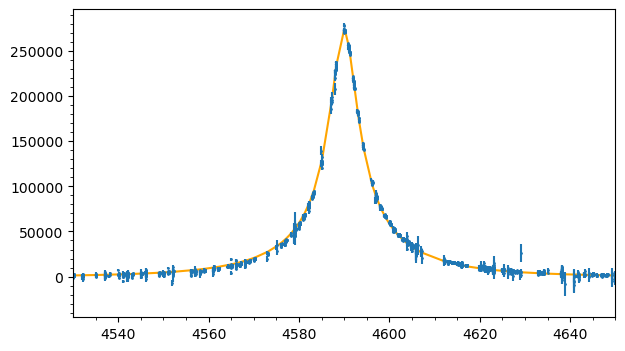

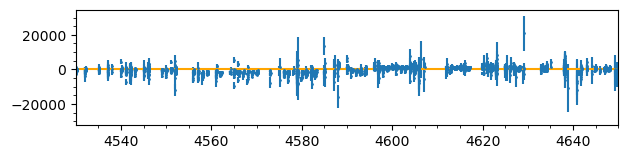

In [7]:
plt.figure(figsize=(7,4))
plt.plot(data["time"],f_fit,c="orange")
plt.errorbar(data["time"],data["flux"],yerr=data["ferr"],fmt="o",markersize=1,capsize=0)

plt.xlim(4530, 4650)
plt.minorticks_on()
plt.show()

plt.figure(figsize=(7,1.5))
plt.errorbar(data["time"],f_residual,yerr=data["ferr"],fmt="o",markersize=1,capsize=0)
plt.plot([4530, 4650], [0, 0], color='orange', linestyle='-')

plt.xlim(4530, 4650)
plt.minorticks_on()
plt.show()

4589.938412087933 27.922935320069286 0.10754558454528262


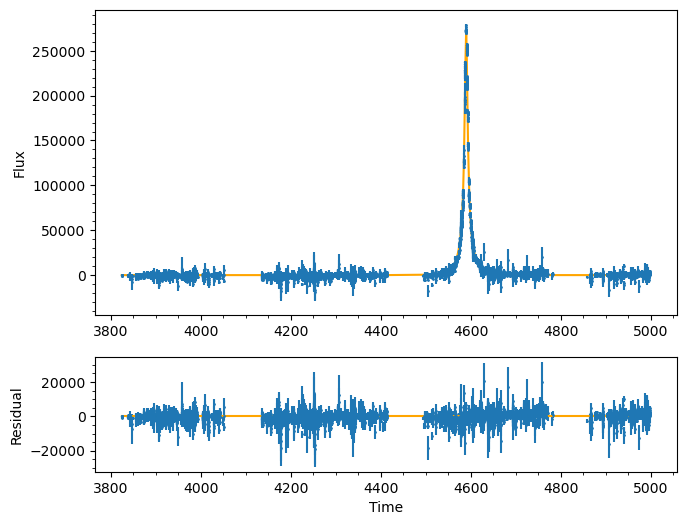

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[8, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.plot(data["time"],f_fit,c="orange")
ax0.errorbar(data["time"],data["flux"],yerr=data["ferr"],fmt="o",markersize=1,capsize=0)
ax0.set_ylabel("Flux")
ax0.minorticks_on()

ax1.errorbar(data["time"],f_residual,yerr=data["ferr"],fmt="o",markersize=1,capsize=0)
ax1.plot([np.min(data["time"]), np.max(data["time"])], [0, 0], color='orange', linestyle='-')
ax1.set_ylabel("Residual")
ax1.set_xlabel("Time")

plt.minorticks_on()

print(t0_fit,tE_fit,u0_fit)

gridの値を設定する　teff は等比数列　t0は等差数列

In [9]:
teff_k1 = 0.3
ratio = 4/3
teff_k = teff_k1 * np.power(ratio, np.arange(13))
chi2_list, t0_ref_list, teff_ref_list, chi2_flat_list, d_chi2_flat_list, chi2_0fit_list, d_chi2_0fit_list =[],[],[],[],[],[],[]

for teff_ref in teff_k:
    dt0 = 1/6 * teff_ref
    t0_start, t0_end = np.min(data["time"]), np.max(data["time"])
#     t0_start, t0_end = t0_fit-tE_fit*20, t0_fit+tE_fit*20, 
    t0_j = np.arange(t0_start, t0_end+dt0,dt0)
    
    for t0_ref in t0_j:
        cond1, cond2 = t0_ref-3*teff_ref <data["time"], data["time"] < t0_ref+3*teff_ref 
        ind=np.where(cond1&cond2)[0]
        if ind.shape[0] == 0:
            chi2 = 0
            chi2_flat = 0
            chi2_0fit = 0
        else:
            chi2 = get_chi2_comb(t0_ref,teff_ref,data["time"][ind],f_residual[ind],data["ferr"][ind])
            chi2_flat = get_chi2_flat(data["time"][ind],f_residual[ind],data["ferr"][ind])
            chi2_0fit = get_chi2_0fit(data["time"][ind],f_residual[ind],data["ferr"][ind])
        dchi2_flat = chi2_flat-chi2
        dchi2_0= chi2_0fit-chi2
        chi2_list.append(chi2)
        t0_ref_list.append(t0_ref)
        teff_ref_list.append(teff_ref)
        chi2_flat_list.append(chi2_flat)
        d_chi2_flat_list.append(dchi2_flat)
        d_chi2_0fit_list.append(dchi2_0)

chi2_array = np.column_stack((t0_ref_list, teff_ref_list,d_chi2_flat_list,d_chi2_0fit_list))

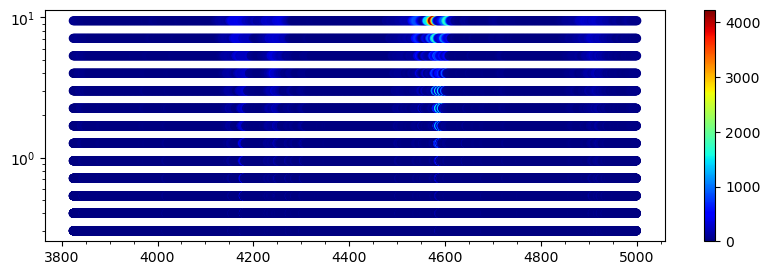

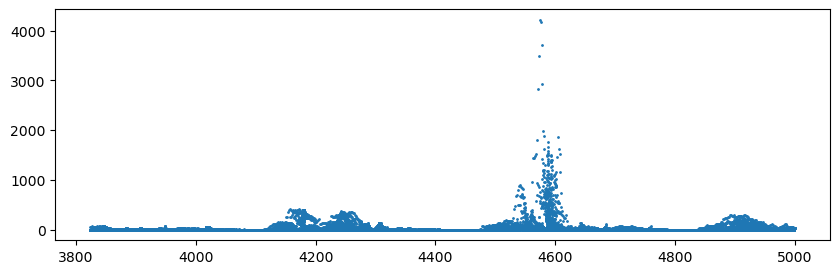

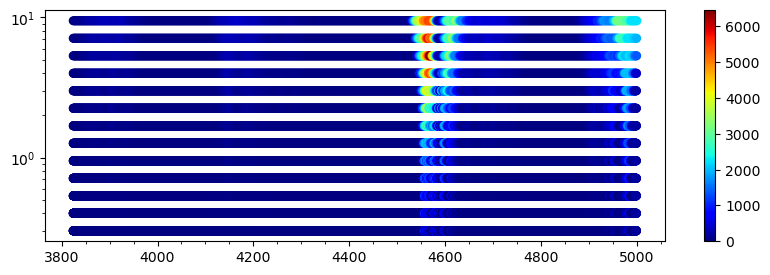

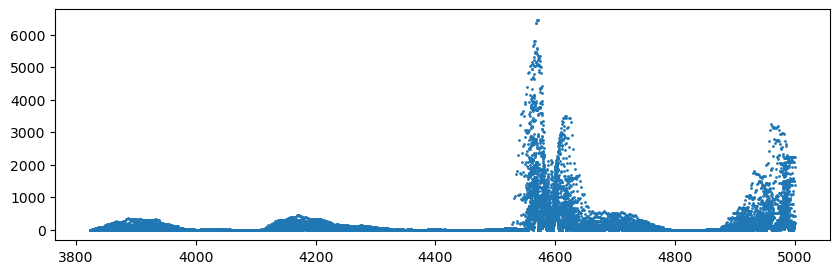

In [10]:
plt.figure(figsize=(10,3))
plt.scatter(chi2_array[:,0],chi2_array[:,1],c=chi2_array[:,2],s=30,cmap="jet")
plt.colorbar()
plt.yscale("log")
# plt.xlim(4530, 4650)
plt.minorticks_on()
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(chi2_array[:,0],chi2_array[:,2],s=1)
# plt.xlim(4530, 4650)
# plt.ylim(-50,1000)
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(chi2_array[:,0],chi2_array[:,1],c=chi2_array[:,3],s=30,cmap="jet")
plt.colorbar()
plt.yscale("log")
# plt.xlim(4530, 4650)
plt.minorticks_on()
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(chi2_array[:,0],chi2_array[:,3],s=1)
# plt.xlim(4530, 4650)
# plt.ylim(-100,10000)
plt.show()

In [11]:
best_grid_ind = np.argmax(chi2_array[:,2])

t0_best, teff_best = chi2_array[best_grid_ind,0], chi2_array[best_grid_ind,1]
cond1, cond2 = t0_best-3*teff_best <data["time"], data["time"] < t0_best+3*teff_best 
ind=np.where(cond1&cond2)[0]

f1_best, f0_best = get_flux_comb(t0_best,teff_best,data["time"][ind],f_residual[ind],data["ferr"][ind])

lc = get_lc_comb(t0_best,teff_best,f1_best,f0_best)

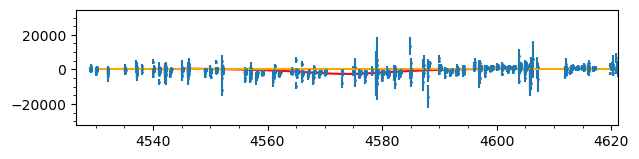

In [12]:
plt.figure(figsize=(7,1.5))
plt.plot(lc["time"],lc["flux"],c="red")

plt.errorbar(data["time"],f_residual,yerr=data["ferr"],fmt="o",markersize=1,capsize=0)
plt.plot([4530, 4650], [0, 0], color='orange', linestyle='-')

plt.xlim(t0_best-5*teff_best,t0_best+5*teff_best)
plt.minorticks_on()

plt.show()

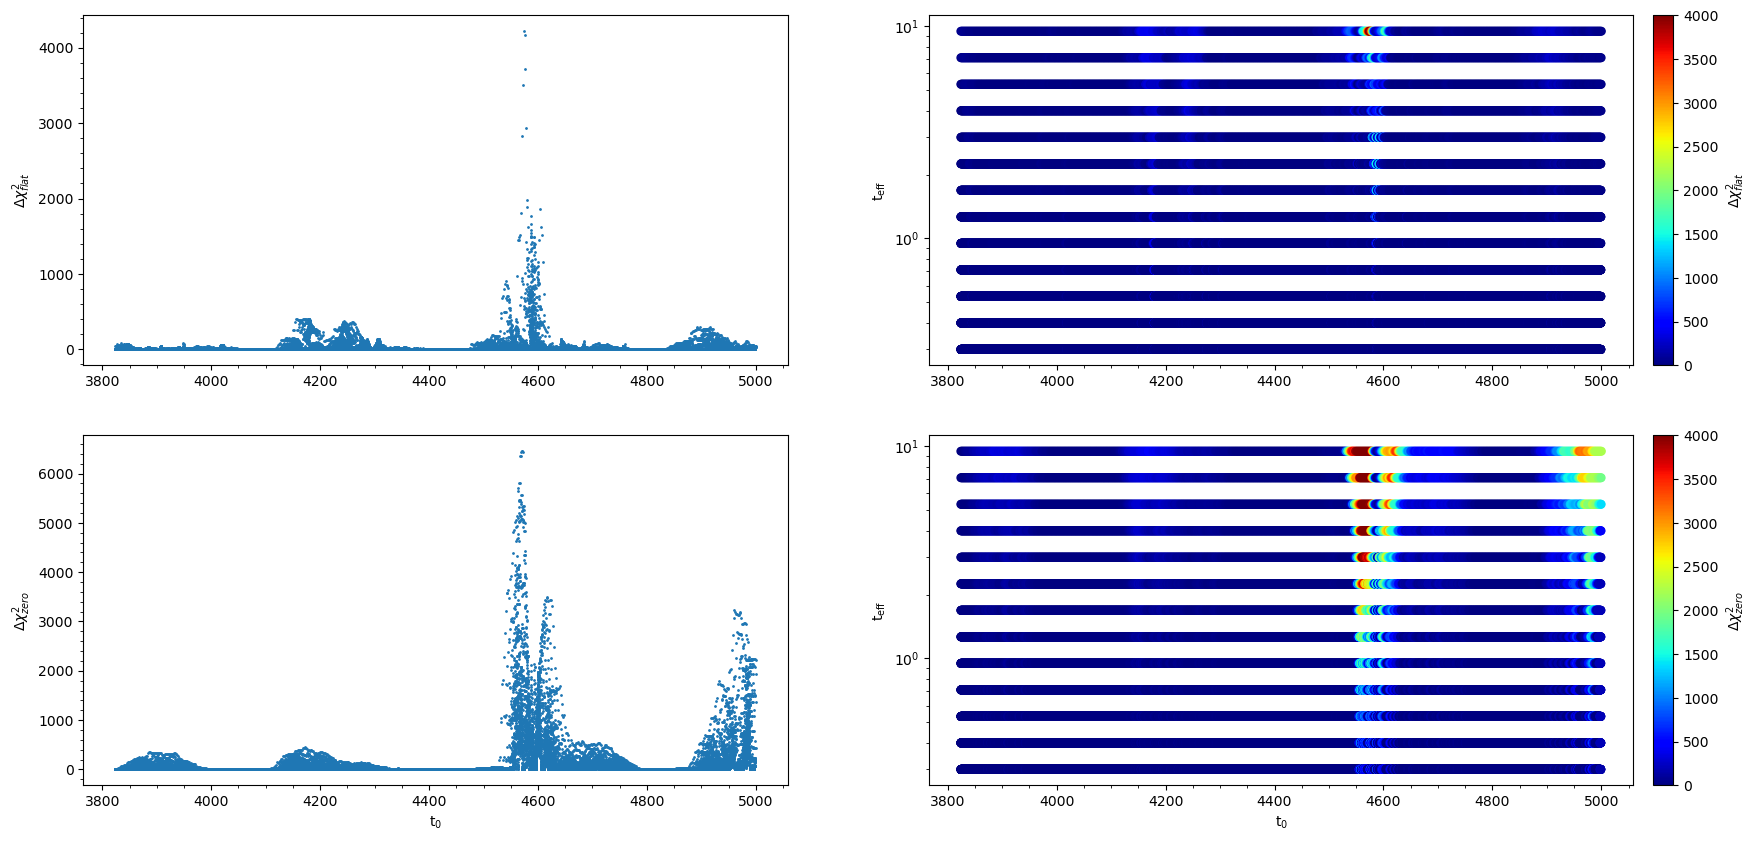

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,0].scatter(chi2_array[:,0],chi2_array[:,2],s=1)
ax[1,0].scatter(chi2_array[:,0],chi2_array[:,3],s=1)
im1= ax[0,1].scatter(chi2_array[:,0],chi2_array[:,1],c=chi2_array[:,2],s=30,vmax=4000,cmap="jet")
im2= ax[1,1].scatter(chi2_array[:,0],chi2_array[:,1],c=chi2_array[:,3],s=30,vmax=4000,cmap="jet")

ax[0,1].set_yscale("log")
ax[1,1].set_yscale("log")

ax[0,0].minorticks_on()
ax[1,0].minorticks_on()
ax[0,1].minorticks_on()
ax[1,1].minorticks_on()

ax[0,0].set_ylabel(r"$\Delta\chi^{2}_{flat}$")
ax[1,0].set_ylabel(r"$\Delta\chi^{2}_{zero}$")
ax[1,0].set_xlabel(r"$\rm t_{\rm 0}$")
ax[1,1].set_xlabel(r"$\rm t_{\rm 0}$")
ax[0,1].set_ylabel(r"$\rm t_{\rm eff}$")
ax[1,1].set_ylabel(r"$\rm t_{\rm eff}$")

cbar_ax1 = fig.add_axes([0.91, 0.53, 0.01, 0.35]) # left, bottom, width, height
cb1 = fig.colorbar(im1, cax=cbar_ax1)
cb1.set_label(r'$\Delta\chi^{2}_{flat}$')

cbar_ax2 = fig.add_axes([0.91, 0.11, 0.01, 0.35]) # left, bottom, width, height
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.set_label(r'$\Delta\chi^{2}_{zero}$')